Attempts to reproduce results in 10.1098/rspa.2022.0568.

In [1]:
from copy import deepcopy
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm

from sde_models import Mamis2023SEIRWN, Mamis2023SEIROU, _Mamis2023SEIR
import sde

store_ssr_data = True
load_ssr_data = False

fig_kwargs = dict(
    layout='compressed',
    figsize=(15.0, 3.0)
)
plot_all_kwargs = dict(
    color='gray',
    alpha=0.1
)

t_fin = 5 * 30.0
dt = 1.0
sample_size = 50000
sigs = [x * Mamis2023SEIROU.parameter_defaults['mu'] for x in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]]
tested_sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000]
confidence = 0.95

results_dir = os.path.join('results', _Mamis2023SEIR.name[:-1])

def initial_values(**kwargs):
    result = {
        'S': 0.8480,
        'E': 0.0014,
        'I': 0.0018,
        'R': 0.1488
    }
    result.update(kwargs)
    result['N'] = sum(result.values())
    result = {k: v * 329.5E6 for k, v in result.items()}
    result['lam'] = Mamis2023SEIROU.parameter_defaults['mu']
    return result

Initial attempts to reproduce using reported initial values and parameters failed. Here integrate corrections that fit the model to reported target data. For details, see associated ODE notebook. 

Note that corrected values requires adaptive time stepping. For details, see sde.py. 

In [2]:
parameters_corrected = dict(
    alp=2.1984892739382698,
    gam=3.8870148747856637,
    mu=4.834404168761199
)
Mamis2023SEIROU.parameter_defaults = deepcopy(parameters_corrected)
Mamis2023SEIRWN.parameter_defaults = deepcopy(parameters_corrected)
sigs = [x * Mamis2023SEIROU.parameter_defaults['mu'] for x in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]]

total_pop = 329.5E6

def initial_values_corrected(**kwargs):
    result = dict(
        E=7.026061194048489e-05,
        I=9.001171228456819e-05,
        R=0.1488
    )
    result['S'] = 1.0 - sum(result.values())
    result.update(kwargs)
    result['N'] = sum(result.values())
    result = {k: v * total_pop for k, v in result.items()}
    result['lam'] = parameters_corrected['mu']
    return result


initial_values = initial_values_corrected

In [3]:
parameters_baseline = deepcopy(Mamis2023SEIRWN.parameter_defaults)
num_steps = int(t_fin / dt)
if sde.get_pool() is None:
    sde.start_pool()

  0%|          | 0/6 [00:00<?, ?it/s]

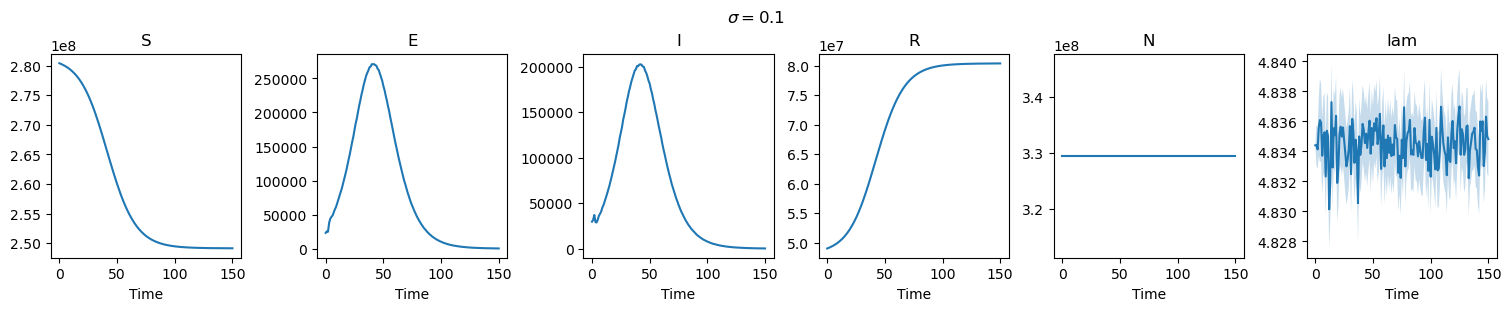

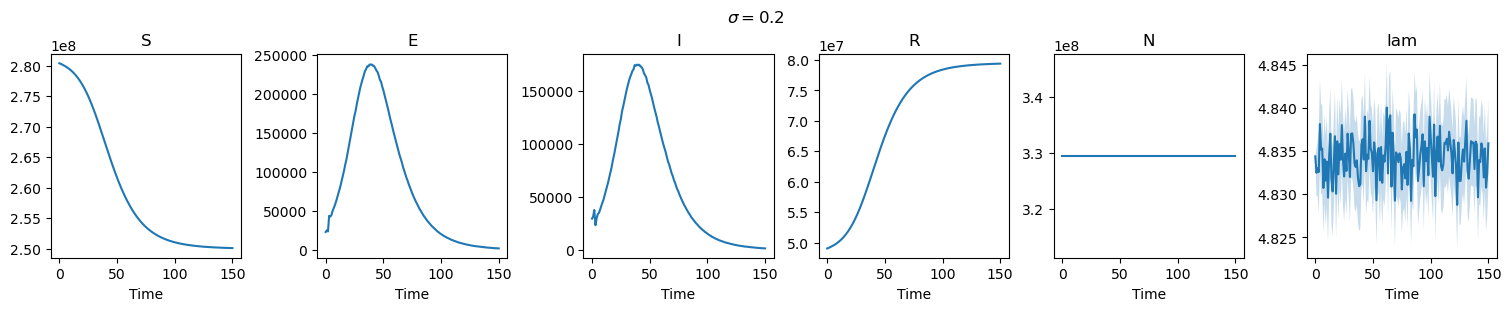

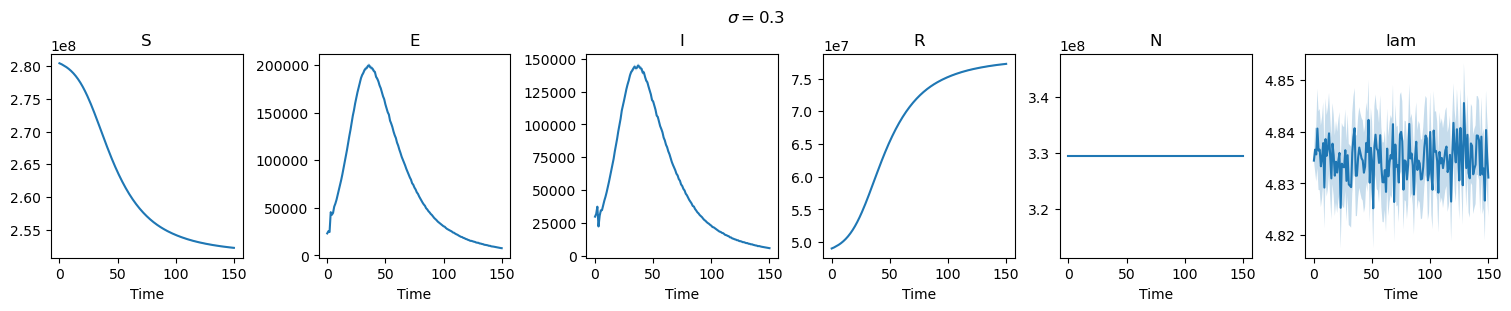

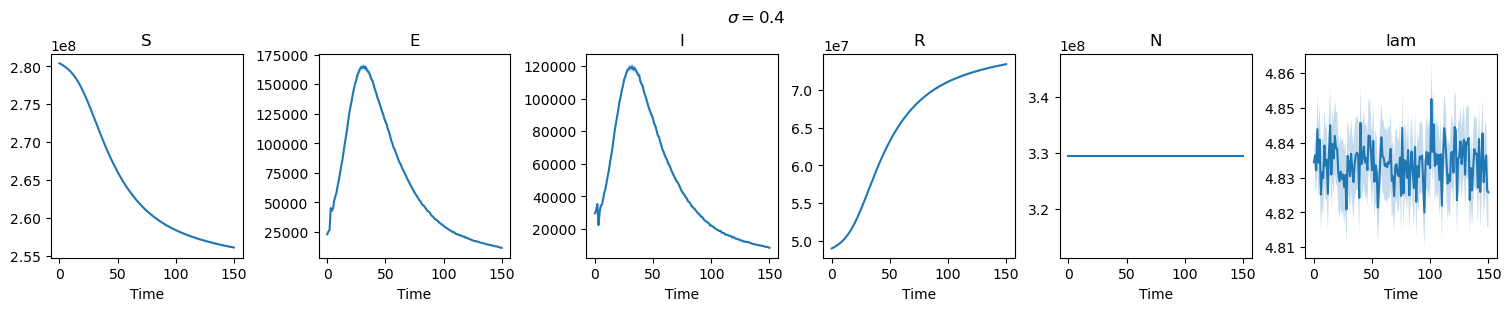

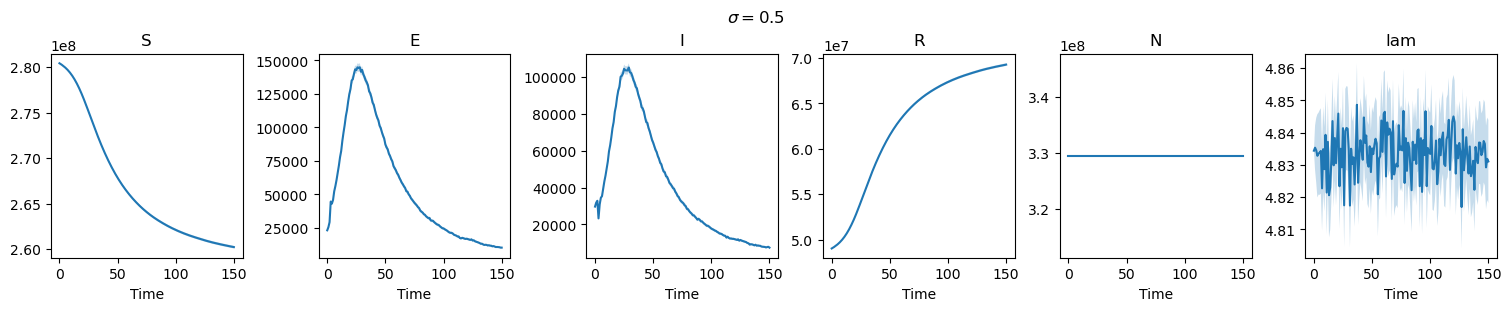

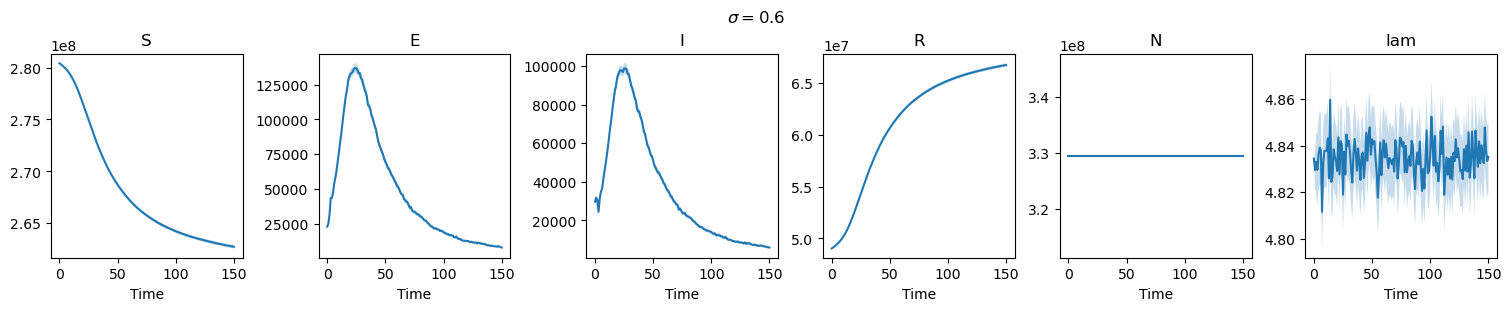

In [4]:
model_wn = Mamis2023SEIRWN()
initial_values_wn = {}
parameters_wn = {}
results_wn = {}
for sig in tqdm(sigs, leave=False):
    initial_values_wn[sig] = initial_values()
    parameters_wn[sig] = deepcopy(parameters_baseline)
    parameters_wn[sig]['sig'] = sig
    results_wn[sig] = sde.execute_sample(sample_size, 
                                         model_wn,
                                         num_steps,
                                         dt,
                                         initial_values_wn[sig],
                                         parameters_wn[sig])
    fig, axs = results_wn[sig].plot_ci(confidence, 
                                       fig_kwargs=fig_kwargs, 
                                       plot_all_kwargs=dict(alpha=0.25))
    results_wn[sig].plot_mean(fig_axs=(fig, axs))
    _ = fig.suptitle(f'$\\sigma={sig / model_wn.parameter_defaults["mu"]}$')

Qualitatively reproduces Figure 3. The extent to which results can be reproduced is comprised by corrections. 

  0%|          | 0/6 [00:00<?, ?it/s]

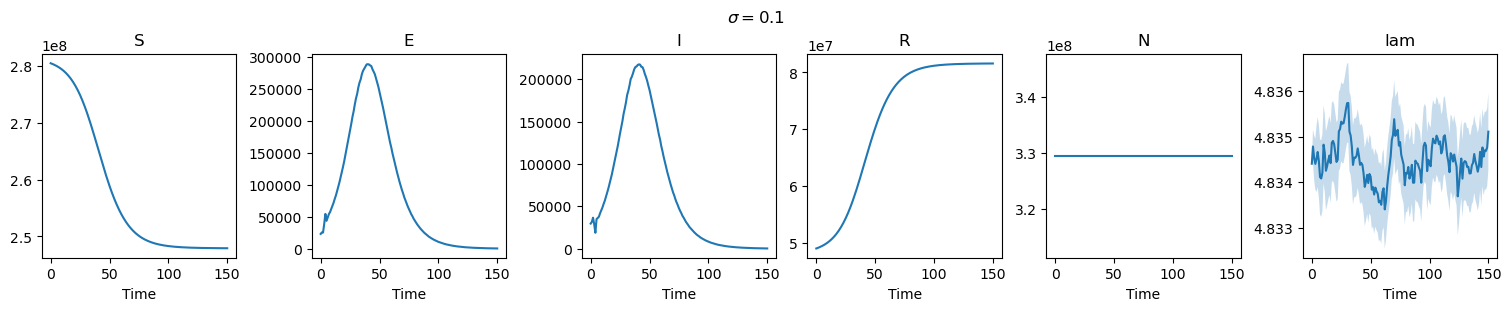

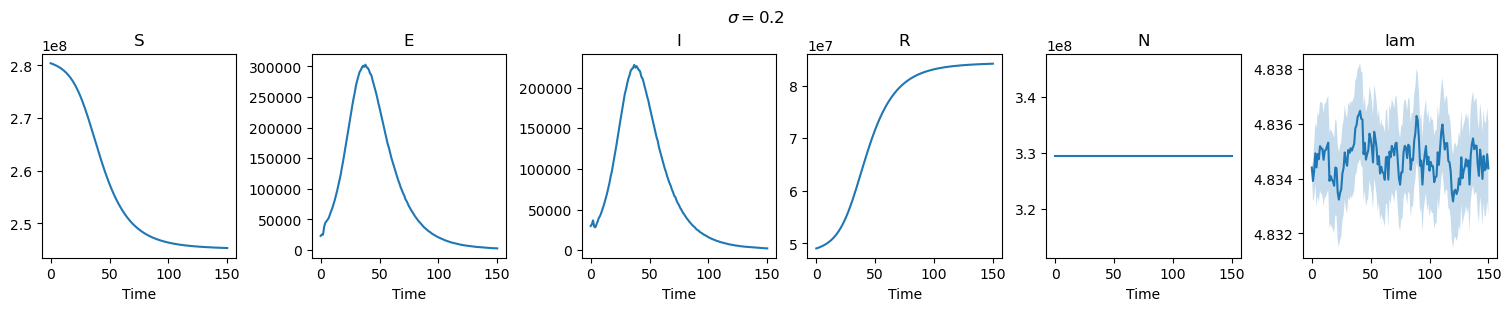

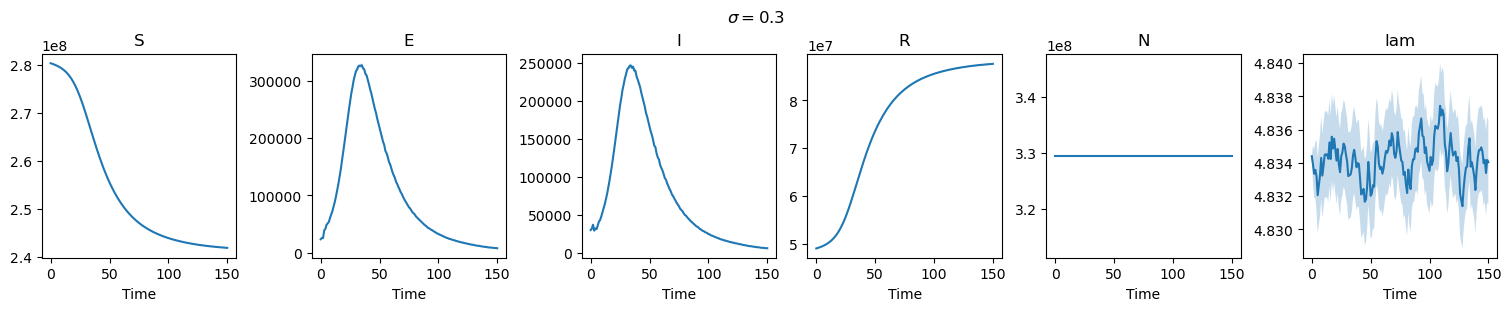

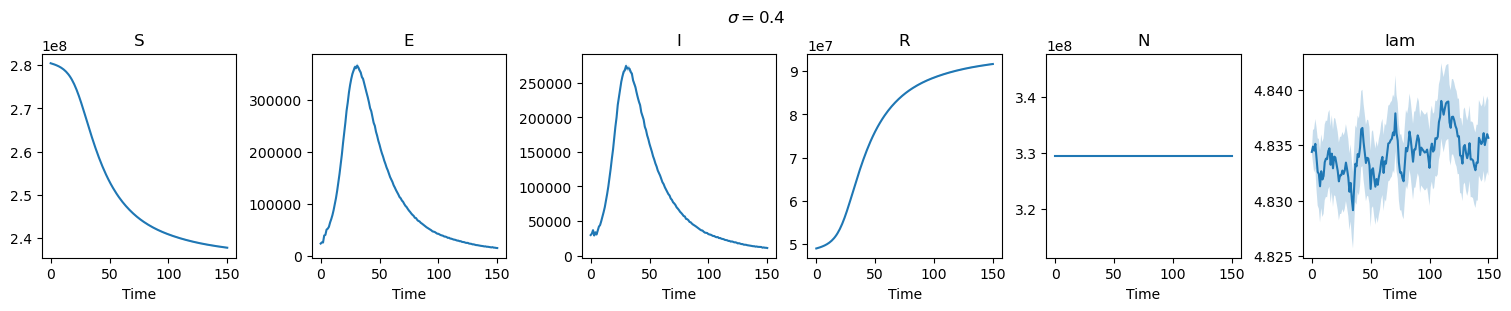

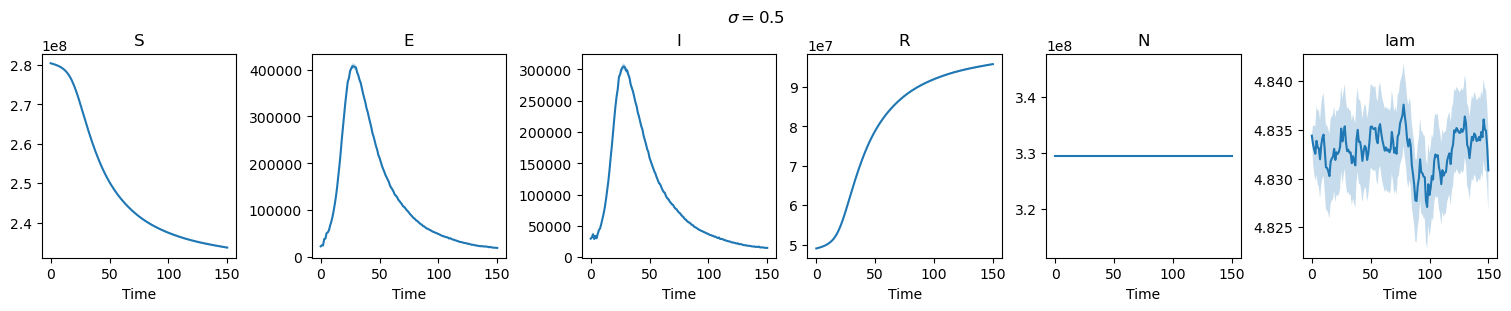

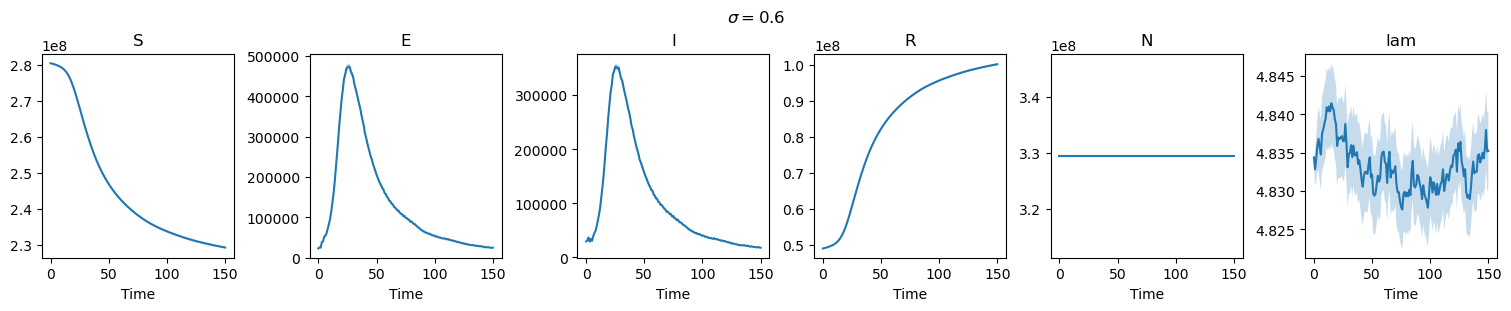

In [5]:
model_ou = Mamis2023SEIROU()
initial_values_ou = {}
parameters_ou = {}
results_ou = {}
for sig in tqdm(sigs, leave=False):
    initial_values_ou[sig] = initial_values()
    parameters_ou[sig] = deepcopy(parameters_baseline)
    parameters_ou[sig]['sig'] = sig
    results_ou[sig] = sde.execute_sample(sample_size, 
                                         model_ou,
                                         num_steps,
                                         dt,
                                         initial_values_ou[sig],
                                         parameters_ou[sig])
    fig, axs = results_ou[sig].plot_ci(confidence, 
                                       fig_kwargs=fig_kwargs, 
                                       plot_all_kwargs=dict(alpha=0.25))
    results_ou[sig].plot_mean(fig_axs=(fig, axs))
    _ = fig.suptitle(f'$\\sigma={sig / model_ou.parameter_defaults["mu"]}$')

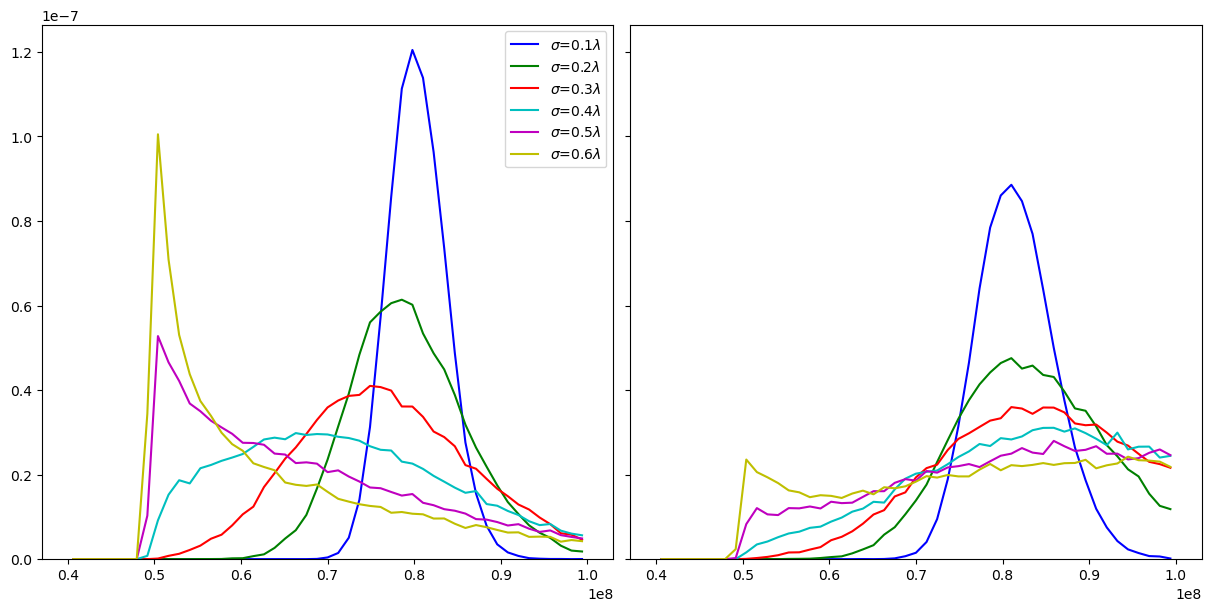

In [6]:
fig, axs = plt.subplots(1, 2, layout='compressed', sharey=True, figsize=(12.0, 6.0))
bins = np.linspace(4E7, 10E7, 50)
sig_colors = list(mcolors.BASE_COLORS.values())
for i, sig in enumerate(sigs):
   n, x, _ = axs[0].hist(results_wn[sig].data[:, results_wn[sig].index('R'), -1], 
                         bins=bins, 
                         density=True, 
                         alpha=0)
   bin_centers = 0.5 * (x[1:] + x[:-1])
   axs[0].plot(bin_centers, n, color=sig_colors[i % len(sig_colors)], 
               label= '$\\sigma$=' + str(sig / model_ou.parameter_defaults['mu']) + '$\lambda$')
   
   n, x, _ = axs[1].hist(results_ou[sig].data[:, results_ou[sig].index('R'), -1], 
                         bins=bins,
                         density=True, 
                         alpha=0)
   bin_centers = 0.5 * (x[1:] + x[:-1])
   axs[1].plot(bin_centers, n, color=sig_colors[i % len(sig_colors)])
_ = axs[0].legend()

Quantify reproducibility of white noise results.

  0%|          | 0/6 [00:00<?, ?it/s]

White Noise EFECT Error (mean +- st. dev)
sigma: 0.48344041687611994
	Sample size 10: 1.3896786001744295 +- 0.06999261400735483
	Sample size 50: 0.6465227263493291 +- 0.03985298811166784
	Sample size 100: 0.4586742382853755 +- 0.027625296388148517
	Sample size 500: 0.20684669018255483 +- 0.012251346350433621
	Sample size 1000: 0.14539792051117625 +- 0.008735856830181861
	Sample size 5000: 0.06522447381790218 +- 0.004365098869789651
	Sample size 10000: 0.046280603787201995 +- 0.0030174885764470733
sigma: 0.9668808337522399
	Sample size 10: 1.3775183639973727 +- 0.07155549872867674
	Sample size 50: 0.641989881070918 +- 0.03795241474422152
	Sample size 100: 0.4563268721512452 +- 0.030552446198761195
	Sample size 500: 0.20503360179475386 +- 0.012802498360518746
	Sample size 1000: 0.14456015148642903 +- 0.009795050341187207
	Sample size 5000: 0.06472383001625168 +- 0.0036991998014391627
	Sample size 10000: 0.045841983466173734 +- 0.00279794491797301
sigma: 1.4503212506283596
	Sample size 10

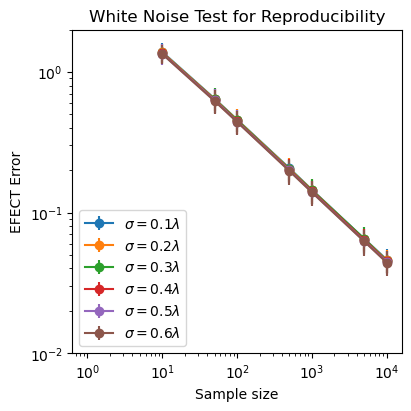

In [7]:
prefix_wn = 'results_wn'

ssr_metadata_wn = {}
ssr_results_wn = {}

if load_ssr_data:
    md_data, res_data, iv_data, p_data, _ = sde.load_ssr_dataset(results_dir, prefix_wn)
    for i in range(len(md_data)):
        v = p_data[i]['sig']
        if v not in ssr_metadata_wn:
            ssr_metadata_wn[v] = {}
            ssr_results_wn[v] = {}
        ssr_metadata_wn[v][md_data[i].sample_size] = md_data[i]
        ssr_results_wn[v][md_data[i].sample_size] = res_data[i]

else:
    for i, v in tqdm(enumerate(results_wn.keys()), total=len(results_wn.keys()), leave=False):
        ssr_metadata_wn[v], ssr_results_wn[v] = sde.generate_ssr_dataset(
            model_wn,
            tested_sample_sizes,
            num_steps,
            dt,
            initial_values_wn[v], 
            parameters_wn[v], 
            prefix_wn + f'_{i}',
            results_dir=results_dir if store_ssr_data else None
        )

fig_ax = None
for v, md in ssr_metadata_wn.items():
    fig_ax = sde.plot_repro(
        md, 
        fig_ax=fig_ax, 
        plot_kwargs=dict(label=f'$\\sigma={v / model_wn.parameter_defaults["mu"]}\\lambda$')
    )
fig_ax[1].set_title('White Noise Test for Reproducibility')
fig_ax[1].legend()

print('White Noise EFECT Error (mean +- st. dev)')
for v in ssr_metadata_wn.keys():
    print(f'sigma: {v}')
    for sz, md in ssr_metadata_wn[v].items():
        print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Quantify reproducibility of Ornstein-Uhlenbeck results.

  0%|          | 0/6 [00:00<?, ?it/s]

Ornstein-Uhlenbeck EFECT Error (mean +- st. dev)
sigma: 0.48344041687611994
	Sample size 10: 1.3784733811822627 +- 0.06802198875102825
	Sample size 50: 0.644093851411417 +- 0.03970053939468737
	Sample size 100: 0.45692424062204506 +- 0.027183029306631624
	Sample size 500: 0.2063797346062334 +- 0.013652483474022472
	Sample size 1000: 0.14563252049680245 +- 0.009162920762811017
	Sample size 5000: 0.06513420972955677 +- 0.004165508189343978
	Sample size 10000: 0.045970027743281835 +- 0.002622719807416329
sigma: 0.9668808337522399
	Sample size 10: 1.3709005651210162 +- 0.07305232346085368
	Sample size 50: 0.6397318474821396 +- 0.036777941116897396
	Sample size 100: 0.45515055883090894 +- 0.02640788851104148
	Sample size 500: 0.203318474939118 +- 0.012155847448461292
	Sample size 1000: 0.14543654400651276 +- 0.008970962021148565
	Sample size 5000: 0.0646629515156189 +- 0.004135455256736029
	Sample size 10000: 0.04556015496133511 +- 0.002955374614012589
sigma: 1.4503212506283596
	Sample size

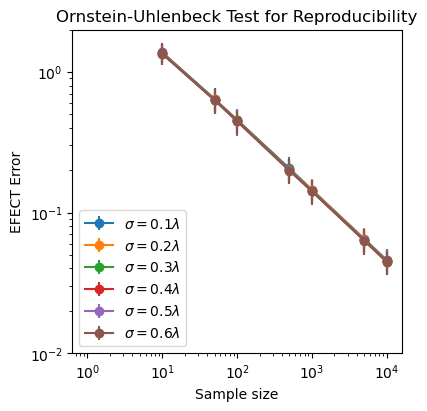

In [8]:
prefix_ou = 'results_ou'

ssr_metadata_ou = {}
ssr_results_ou = {}

if load_ssr_data:
    md_data, res_data, iv_data, p_data, _ = sde.load_ssr_dataset(results_dir, prefix_ou)
    for i in range(len(md_data)):
        v = p_data[i]['sig']
        if v not in ssr_metadata_ou:
            ssr_metadata_ou[v] = {}
            ssr_results_ou[v] = {}
        ssr_metadata_ou[v][md_data[i].sample_size] = md_data[i]
        ssr_results_ou[v][md_data[i].sample_size] = res_data[i]

else:
    for i, v in tqdm(enumerate(results_ou.keys()), total=len(results_ou.keys()), leave=False):
        ssr_metadata_ou[v], ssr_results_ou[v] = sde.generate_ssr_dataset(
            model_ou,
            tested_sample_sizes,
            num_steps,
            dt,
            initial_values_ou[v], 
            parameters_ou[v], 
            prefix_ou + f'_{i}',
            results_dir=results_dir if store_ssr_data else None
        )

fig_ax = None
for v, md in ssr_metadata_ou.items():
    fig_ax = sde.plot_repro(
        md, 
        fig_ax=fig_ax, 
        plot_kwargs=dict(label=f'$\\sigma={v / model_ou.parameter_defaults["mu"]}\\lambda$')
    )
fig_ax[1].set_title('Ornstein-Uhlenbeck Test for Reproducibility')
fig_ax[1].legend()

print('Ornstein-Uhlenbeck EFECT Error (mean +- st. dev)')
for v in ssr_metadata_ou.keys():
    print(f'sigma: {v}')
    for sz, md in ssr_metadata_ou[v].items():
        print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Generate reproducible white noise results.

  0%|          | 0/3 [00:00<?, ?it/s]

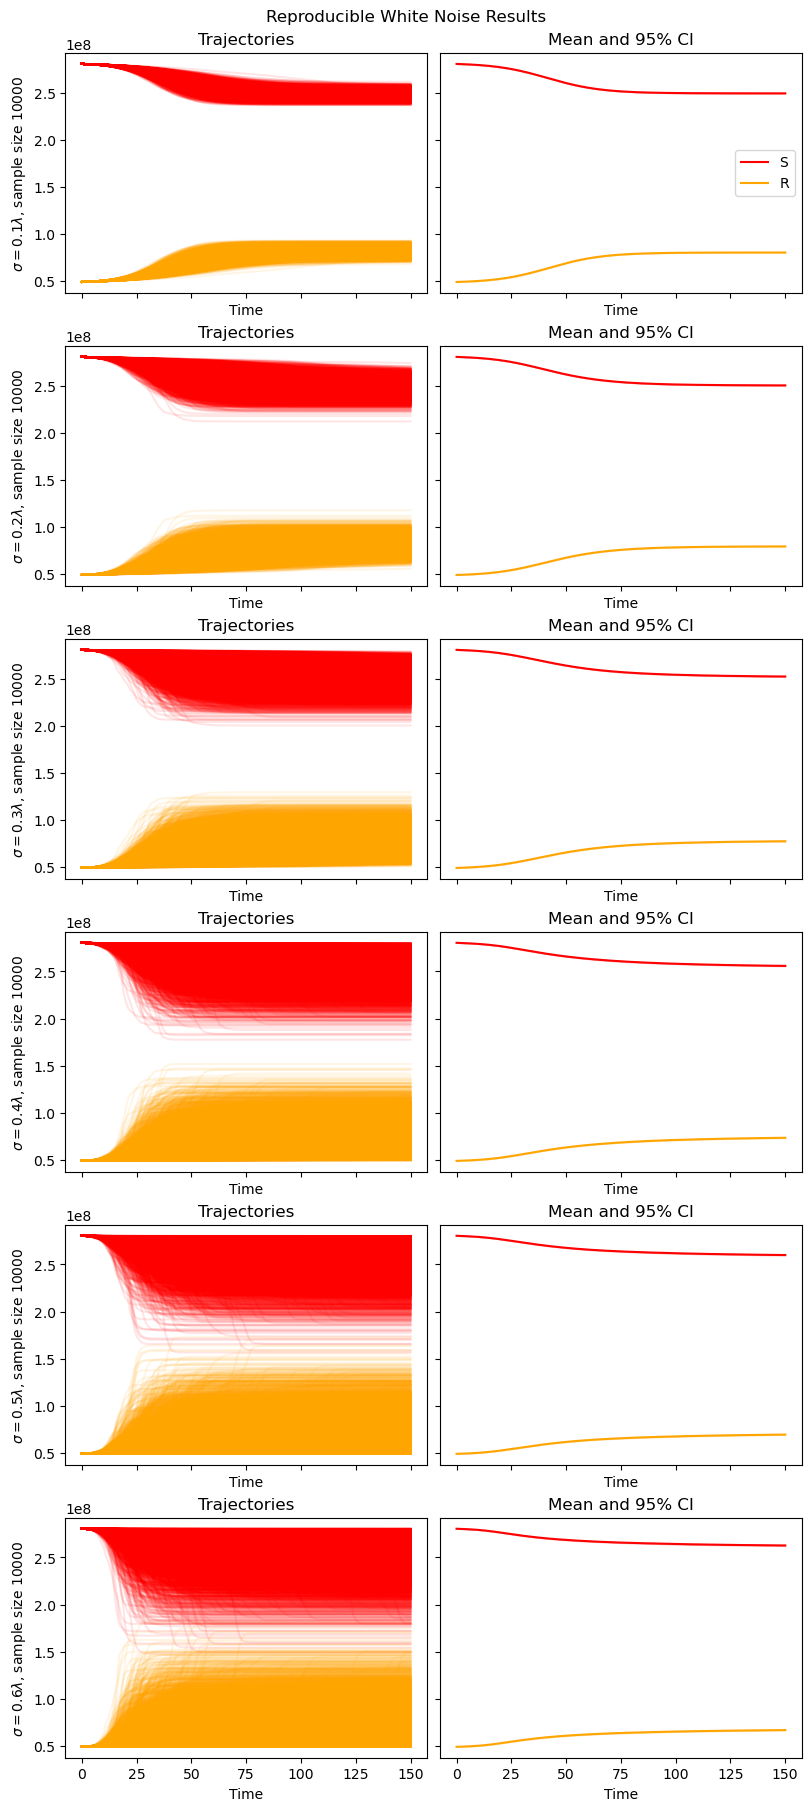

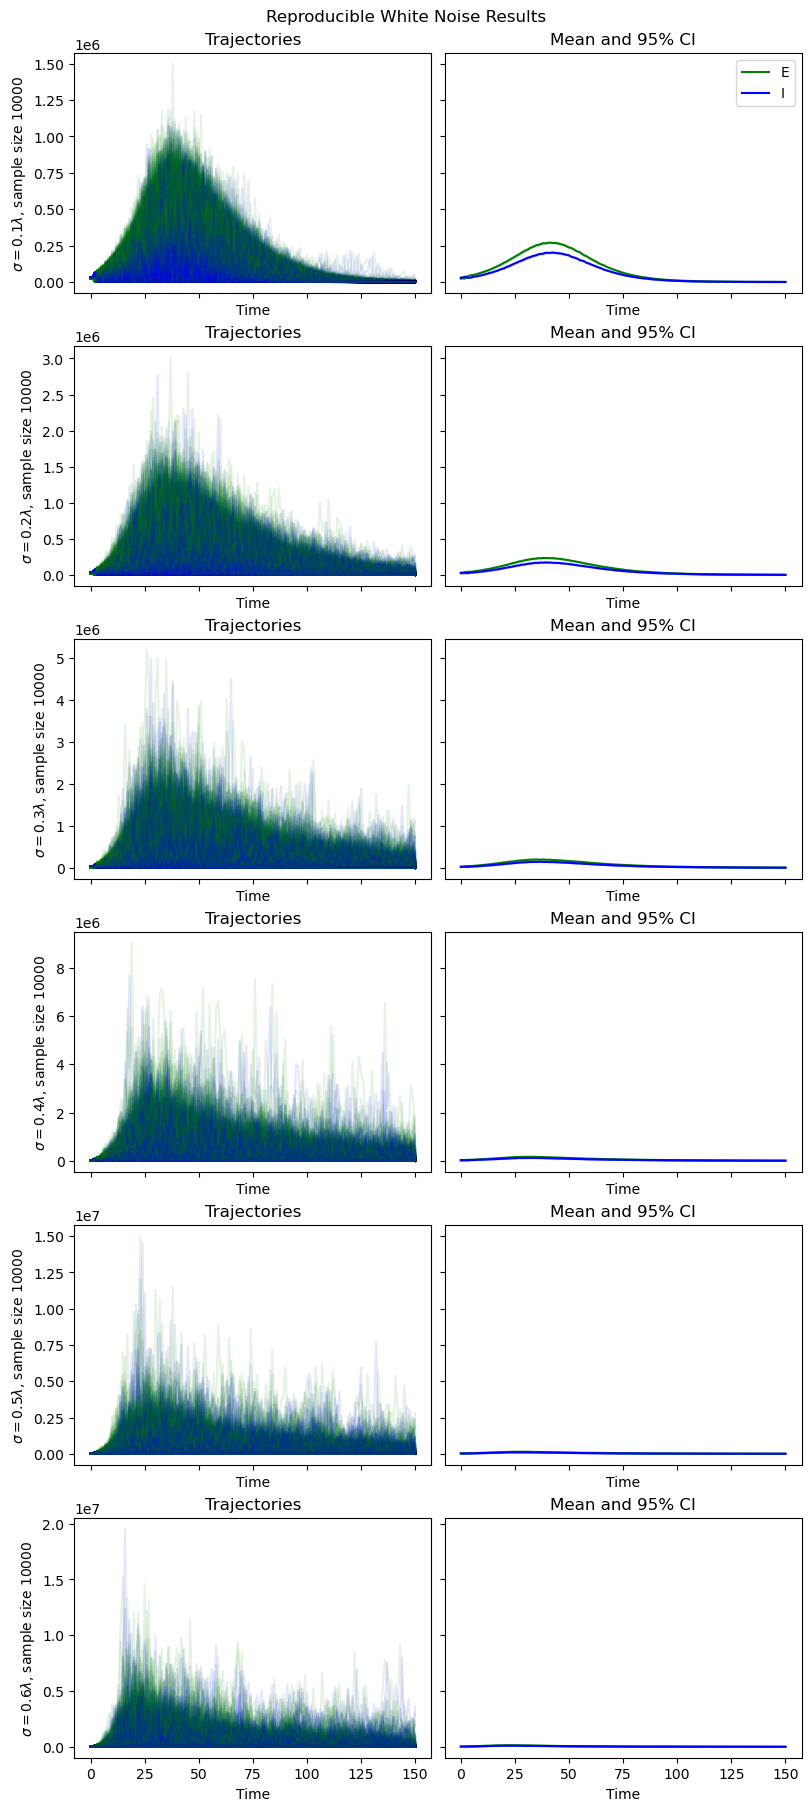

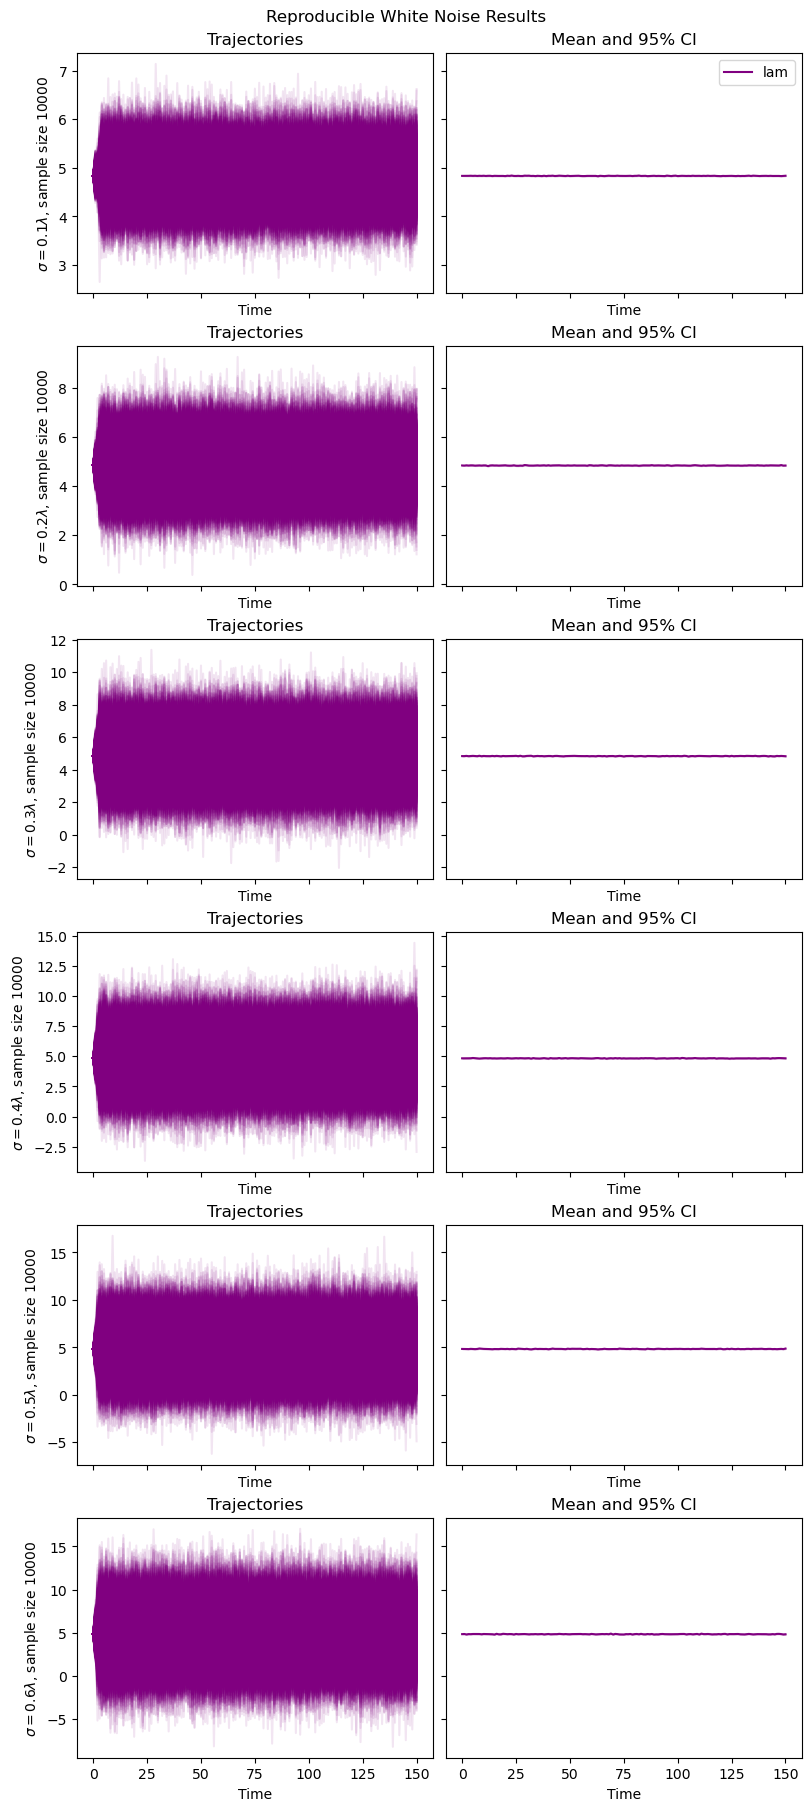

In [9]:
# Split plots by SR, EI, and lam, since scales are very different

plot_colors_repro = {
    'S': 'red',
    'E': 'green',
    'I': 'blue',
    'R': 'orange',
    'N': 'black',
    'lam': 'purple'
}
plot_names_repro = [('S', 'R'), ('E', 'I'), ('lam',)]


def do_repro_plot(res, model, *names):
    fig, axs = plt.subplots(len(res.keys()), 
                            2, 
                            sharex=True, sharey='row', 
                            layout='compressed',
                            figsize=(8.0, 3.0 * len(res.keys())))

    res_sig = {k: {kk: vv.extract(*names) for kk, vv in v.items()} for k, v in res.items()}

    for i, sig in enumerate(res_sig.keys()):
        res = res_sig[sig]
        ssr_results_sz = max(res.keys())

        r: sde.SDEResultSample = res[ssr_results_sz]
        r.plot(fig_axs=(fig, [axs[i][0]] * len(r.var_names)),
            plot_all_kwargs=dict(alpha=0.1),
            plot_kwargs={n: dict(color=plot_colors_repro[n]) 
                            for n in r.var_names})

        r.plot_ci(confidence, fig_axs=(fig, [axs[i][1]] * len(r.var_names)),
                    plot_all_kwargs=dict(alpha=0.25),
                    plot_kwargs={n: dict(color=plot_colors_repro[n]) 
                                for n in r.var_names})
        r.plot_mean(fig_axs=(fig, [axs[i][1]] * len(r.var_names)),
                    plot_kwargs={n: dict(color=plot_colors_repro[n], label=n) 
                                for n in r.var_names})
        
        axs[i][0].set_ylabel(f'$\\sigma={sig / model.parameter_defaults["mu"]}\\lambda$, sample size {ssr_results_sz}')
        axs[i][0].set_title('Trajectories')
        axs[i][1].set_title(f'Mean and {int(confidence * 100)}% CI')

    axs[0][1].legend()

    return fig, axs


for names in tqdm(plot_names_repro, leave=False):
    fig, axs = do_repro_plot(ssr_results_wn, model_wn, *names)
    _ = fig.suptitle('Reproducible White Noise Results')

Generate reproducible Ornstein-Uhlenbeck results.

  0%|          | 0/3 [00:00<?, ?it/s]

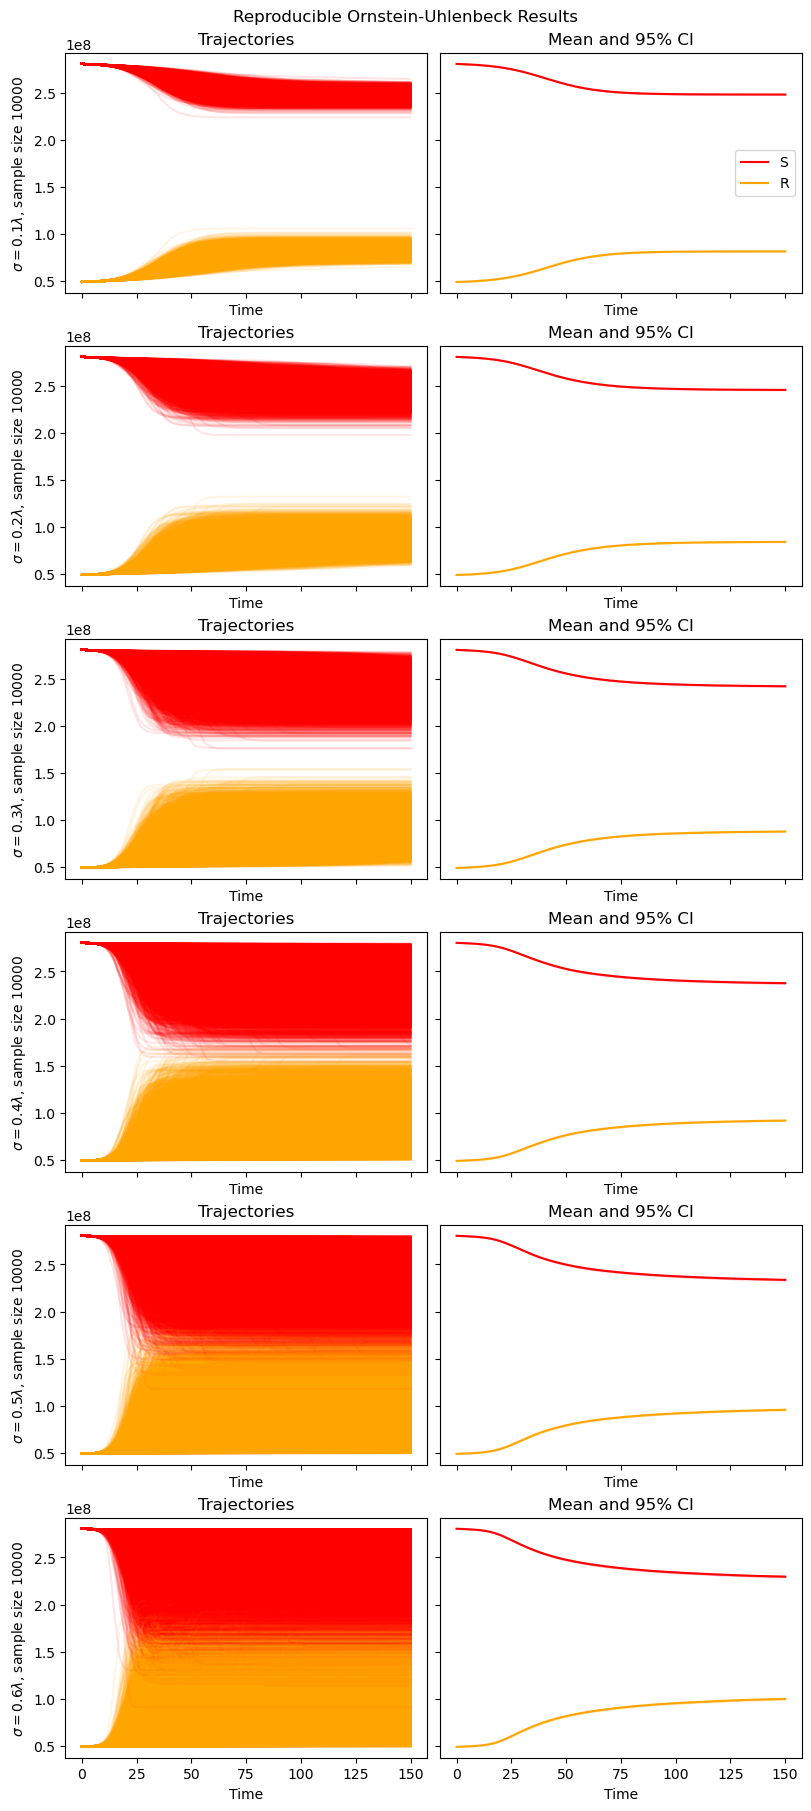

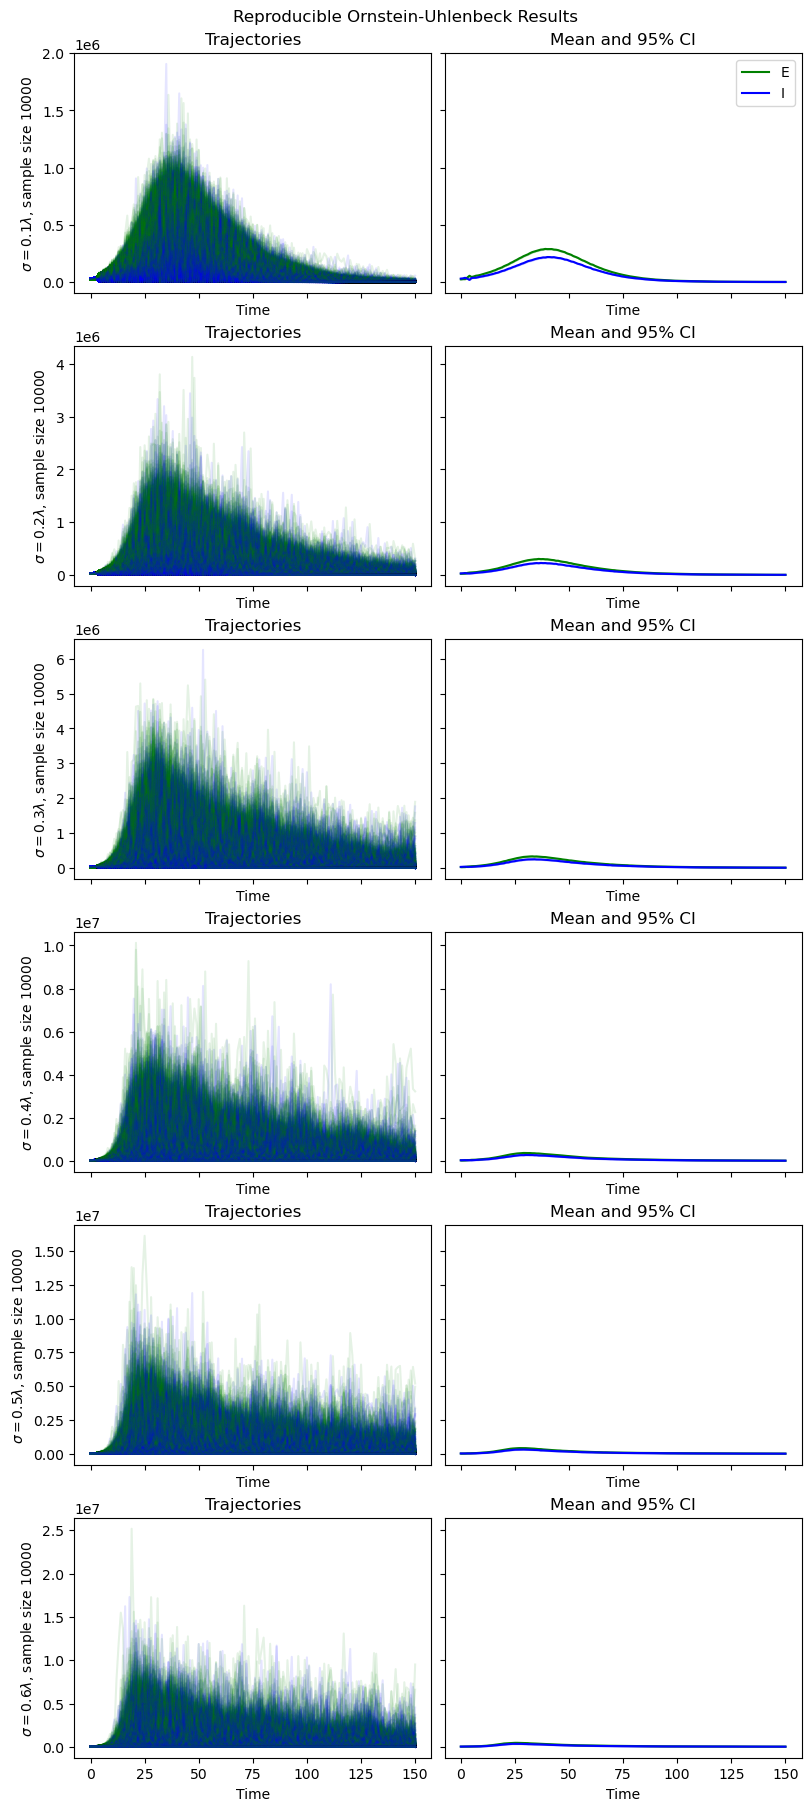

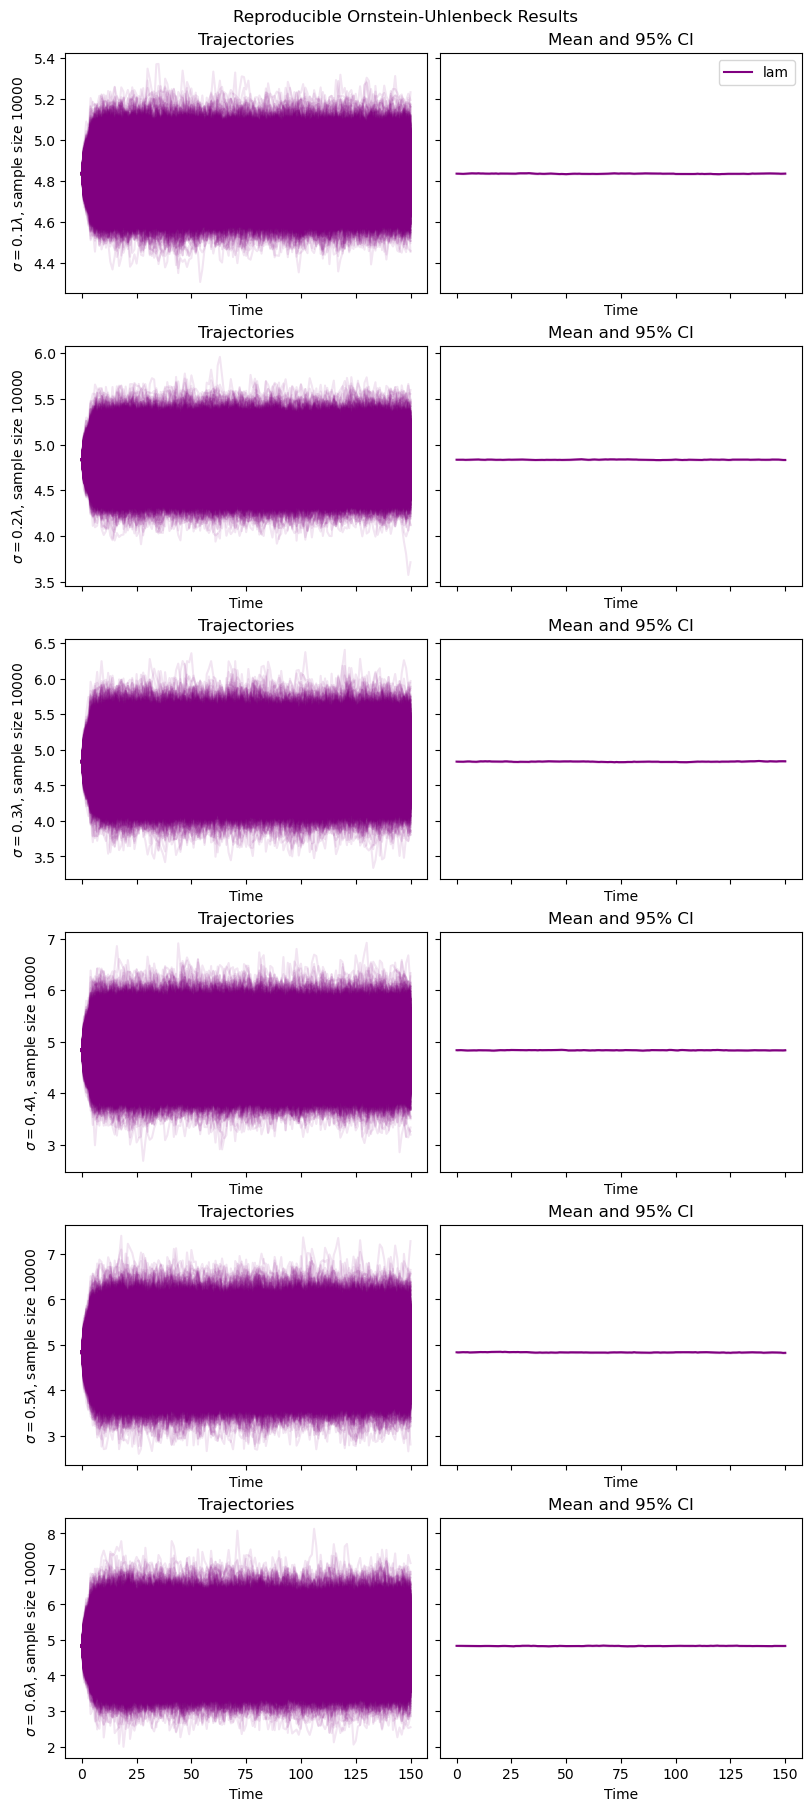

In [10]:
for names in tqdm(plot_names_repro, leave=False):
    fig, axs = do_repro_plot(ssr_results_ou, model_ou, *names)
    _ = fig.suptitle('Reproducible Ornstein-Uhlenbeck Results')